# Graph Scoped DAO
A proof of concept graph network that provides implicit scope through the structure of its votable interactions.  All actions of the DAO are modelled as actor/resrouce actions.  The set of actions is used to build and visualize the DAO.  Continuous staking on actions causes stateful updates of resources controlled by the DAO via the actor/resource actions.  

**Benefits:**
- Formal analysis of actors, resources possible.
- Participant values can be added in multiple places and modelled - choosing what edges exist as well as how the actions are activated.
- The graph has explicit scope and that scope can be visualized.  Artist rendering of how the system is controlled can be made 'to scale'.
- Scalable and dockable.  Very complex governance can be modelled and added in pieces with open verification of interacting elements and modelling of the system available at every change.  A huge improvement over subjective law.

**Cons:**
- Everything is explicit. Implicit governance can only be done through vague actions.
- Fluidity and timing of state updates is another layer of complexity.  May need a structure to control state updates. 
- Disaster recovery must be modelled in.
- Even a simple graph or simple vote activation function may lead to complex, unwanted, behaviors unseen before.


## Goals of Standard Construction and Primitives

1. A DAO is only valid if it can be represented as a fully connected graph.
2. A DAO is only valid if it defines its own external interface.
3. A DAO is only valid if it controls its own data.
4. A DAO is only valid if it can be formally compiled into a set of valid smart contracts.

## Composing Primitives

## The Action

A class of actor, resource(s), and functions with side effects on those resource(s).  A resource can be an actor itself for more complicated graphs.

In [1]:
from pydantic import BaseModel
from typing import List, Dict, Any


class Resource(BaseModel):
    identifier: str

    def __repr__(self):
        return self.identifier
    
        
class Actor(Resource):
    identifier: str
        
    def __repr__(self):
        return self.identifier


class Contract(BaseModel):
    identifier: str
    kwargs: Dict[str, Resource]
    fn: Any
    
    def execute(self):
        try:
            self.fn(self.kwargs)
        except Exception as e:
            print('Error: could not execute contract')
            raise e
    

class Action(BaseModel):
    identifier: str
    actor: Actor
    resources: List[Resource]
    contract: Contract
        
    @property
    def nodes(self) -> list:
        n = []
        n.extend([r.identifier for r in self.resources])
        n.extend([self.actor.identifier])
        return n
    
    @property
    def edges(self) -> list:
        e = []
        e.extend([(self.actor.identifier, r.identifier, {'contract':self.contract}) for r in self.resources])
        return e

In [2]:
# A resource can be scarce or restricted object (this can be a wallet, login service, payment authorization token api, whatever)
wallet = Resource(identifier='00x1')

# An actor should be required by the contract function, otherwise the edge is meaningless.
me = Actor(identifier='JD')

# A contract is any function of named arguments.  
#  This can certainly be a smart contract, but side effects don't have to be on chain.
contract = Contract(
    identifier = 'simple_print',
    kwargs = {'owner': me, 'wallet': wallet}, 
    fn = lambda kw: print(f"{kw['owner'].identifier} owns {kw['wallet'].identifier}"
))

# The Action is an edge of the network.  We define actions and build the network from concrete actions
#  opposed 
print_info = Action(
    identifier='p1',
    actor=me, 
    resources=[wallet], 
    contract=contract)

print_info.contract.execute()  # In practice, executed by stake net

JD owns 00x1


# The Graph
By registering actions, a graph can be built.

In [3]:
import networkx as nx

class DGraph():
    def __init__(self):
        self.__g = nx.Graph()
        
    def register_action(self, action: Action):
        self.__g.add_nodes_from(action.nodes)
        self.__g.add_edges_from(action.edges)
        print(f"added {action.nodes}, {action.edges}")
        
    @property
    def num_nodes(self):
        return self.__g.number_of_nodes()
    
    @property
    def num_edges(self):
        return self.__g.number_of_edges()
    
    @property
    def nodes(self):
        return self.__g.nodes
    
    @property
    def edges(self):
        return self.__g.edges
    
    def get_edge(self, a, b):
        return self.__g[a][b]
    
    def draw(self, *args, **kwargs):
        nx.draw(self.__g, *args, **kwargs)

In [4]:
# Register actions to build the graph
dg = DGraph()
dg.register_action(print_info)

added ['00x1', 'JD'], [('JD', '00x1', {'contract': Contract(identifier='simple_print', kwargs={'owner': JD, 'wallet': 00x1}, fn=<function <lambda> at 0x7fb03c839430>)})]


In [5]:
dg.num_nodes, dg.num_edges

(2, 1)

In [6]:
dg.nodes

NodeView(('00x1', 'JD'))

In [7]:
dg.edges

EdgeView([('00x1', 'JD')])

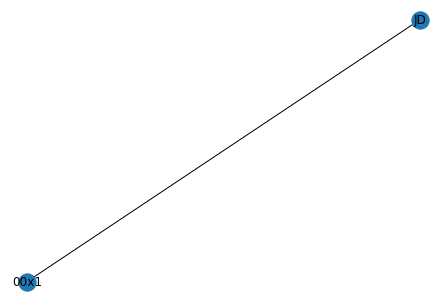

In [8]:
# Visualize the graph (it's very simple now)
dg.draw(with_labels=True)

# Building Up Complexity, Interfaces, Utility
Integrating stake is a modular fashion can be done in many different ways.  Here, I model it based on a vector of votes on actions.  The main thing is to note that many interpretations of voting pattern are easier to exploit when you have an explicit vector of rational quantities tied to known, validated, actions.

## A More complex graph
Let's emulate a more complex graph, for example an election.

added ['Mary', 'elector'], [('elector', 'Mary', {'contract': Contract(identifier='elector_Mary', kwargs={'elector': elector, 'candidate': Mary}, fn=<function elect at 0x7fb0106475e0>)})]
added ['John', 'elector'], [('elector', 'John', {'contract': Contract(identifier='elector_John', kwargs={'elector': elector, 'candidate': John}, fn=<function elect at 0x7fb0106475e0>)})]
added ['Tsu', 'elector'], [('elector', 'Tsu', {'contract': Contract(identifier='elector_Tsu', kwargs={'elector': elector, 'candidate': Tsu}, fn=<function elect at 0x7fb0106475e0>)})]
added ['Ali', 'elector'], [('elector', 'Ali', {'contract': Contract(identifier='elector_Ali', kwargs={'elector': elector, 'candidate': Ali}, fn=<function elect at 0x7fb0106475e0>)})]


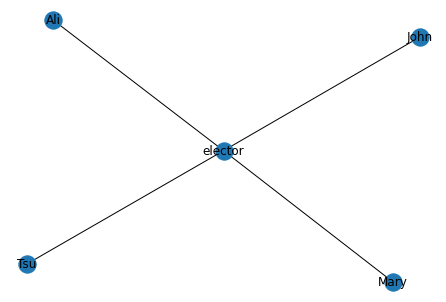

In [9]:
# Elector <- The actor that will actually select the winner whatever that means

elector = Actor(identifier='elector')

# Candidates
candidates = [
    Actor(identifier='Mary'),   # Remember an actor is a resource. Using 'Actor' here for semantic comfort
    Actor(identifier='John'),
    Actor(identifier='Tsu'),
    Actor(identifier='Ali'),
]

# Function & Contracts
def elect(kwargs):
    print(f"{kwargs['elector']} has chosen {kwargs['candidate']} as the winner!")
    
contracts = []
for candidate in candidates:
    contracts.append(
        Contract(
            identifier=f"elector_{candidate.identifier}",
            kwargs={'elector': elector, 'candidate': candidate},
            fn = elect
        )
    )
    
# Actions
actions = []
for candidate, contract in zip(candidates, contracts):
    actions.append(
            Action(
            identifier=candidate.identifier,
            actor=elector,
            resources=[candidate], 
            contract=contract
        )
    )
    

# Build the graph
dg = DGraph()
for action in actions:
    dg.register_action(action)
    
# Visualize the graph
dg.draw(with_labels=True)

## Build The Voting Vector - An Emergent Structure
Create a voting vector tied to each edge.  This is a somewhat naturally occuring structure built from the graph itself, not a separate primitive.  Where and when the data is stored needs further discussion.  Data primitives (where the data/verfications actually reside) is another topic.

In [10]:
class VoteRecord():
    def __init__(self):
        self.__record = {}
        self.__index = None
    
    @property
    def record(self):
        return self.__record
    
    @property
    def index(self):
        if self.__index is None:
            self.__index = {}
            for i, val in enumerate(self.__record.keys()):
                self.__index[i] = val
        return self.__index
    
    def build_from_graph(self, graph: DGraph):
        for nt in graph.edges:
            edge = graph.get_edge(*nt)  # I am starting to abuse/drift/make ugly the networkX API here. sorry
            self.__record[edge['contract'].identifier] = 0
            
    def vote(self, idx):
        contract = self.__index[idx]
        self.__record[contract] += 1
            
    

In [11]:
vr = VoteRecord()
vr.build_from_graph(graph=dg)

In [12]:
vr.record, vr.index

({'elector_Mary': 0, 'elector_John': 0, 'elector_Tsu': 0, 'elector_Ali': 0},
 {0: 'elector_Mary', 1: 'elector_John', 2: 'elector_Tsu', 3: 'elector_Ali'})

In [13]:
## Let's do some random voting
import random

for _ in range(1000):
    vr.vote(random.randint(0, len(vr.index)-1))

vr.record

{'elector_Mary': 248,
 'elector_John': 229,
 'elector_Tsu': 245,
 'elector_Ali': 278}

## Activations
Now we can decide which edges to activate.  This logic can be as simple or complex as required.  Activations are primitives as well.  Further discussion is needed to refine interface and activation primitives.

In [14]:
# Example of an activation function that reads from an emergent structure (voting record)

# Ultimate Voting Decision Making Ultimate Function of Ultimate
def choose_winner(vr: VoteRecord):
    sorted_votes = sorted(vr.record.items(), key=lambda x: -x[1])
    winner = sorted_votes[0]
    return winner[0]

In [15]:
winner = choose_winner(vr)
winner

'elector_Ali'

In [16]:
# Activate the winner!
dg.get_edge(*winner.split('_'))['contract'].execute()

identifier='elector' has chosen identifier='Ali' as the winner!


## Extending Actor to signer, Coalition
The actor is a unique resource in DAOs due to its ability to agree to sign a transaction.  

An actor or acting body does not need to represent a single person or entity, but instead may be a dyad (2 parallel or serial actors) or a coalition (many).

Here we add these features to actor in a composable fashion.  
1. Consensus
2. Sign

If self.consensus(), sign(tx).

In [5]:
from pydantic import BaseModel
from typing import Any

from primitives.resources import Resource
from utils.signatures import add_general_signature


class Consensus(BaseModel):
    fn: Any
        
    def resolve(self, *args, **kwargs):
        return self.fn(*args, **kwargs)
        

class Actor(Resource):
    identifier: str
    consensus: Consensus
    key: str
    
    def __repr__(self):
        return self.identifier
    
    def sign(self, transaction):
        # Add a signature
        if self.consensus.resolve():
            return add_general_signature(self.identifier, self.key, transaction)
        else:
            raise ValueError(f'{self.identifer} Consensus not True')

In [6]:
# Let's see how a simple entity that always returns true signs a transaction

def return_true(): return True

simple_actor = Actor(
    identifier='simpleEnt',
    consensus=Consensus(fn=return_true),
    key='TheMostSecureKeyEver1!',
)

simple_transaction = {'SomeData': 'ThatMeansSomething'}

simple_actor.sign(simple_transaction)

{'SomeData': 'ThatMeansSomething',
 'signatures': [{'simpleEnt': '6daa4542b94c91d4674e4027d222de56'}]}

### Building the multi actor entity as a composition of actors
We'll create a composable coalition of multiple actors that takes its own consensus function.  For simplicity sake, we'll have everyone sign and not use a more dense composite signature.

In [4]:
from typing import List

class Coalition(Actor):
    actors: List[Actor]
        
    def sign(self, transaction):
        if self.consensus.resolve(self.actors):
            for actor in self.actors:
                add_general_signature(actor.identifier, actor.key, transaction)
            return transaction
        else:
            raise ValueError(f'{self.identifer} Consensus not True')

In [6]:
import random

from utils.signatures import add_general_signature

# Create a simple aggregate consensus function (this could be anything), we'll just say All TRUE
def check_all_true(actors: List[Actor], i=0) -> bool:
    if i < len(actors):
        if actors[i].consensus.resolve():
            check_all_true(actors, i + 1)
        else:
            return False
    return True

# Create a few actors
actors = [
    Actor(
        identifier=i, 
        consensus=Consensus(fn=return_true), 
        key=str(random.randint(10000,1000000))
    ) 
    for i in range(5)
]

# Build Coalition
simple_coalition = Coalition(
    identifier='SimpleCoalition',
    actors=actors,
    consensus=Consensus(fn=check_all_true),
    key='SimpleGroupKey@PowerOfMany')

# Have the coalition sign a simple transaction
simple_transaction = {'SomeNewData': 'ThatACoalitionThinksIsImportant'}
simple_coalition.sign(simple_transaction)

{'SomeNewData': 'ThatACoalitionThinksIsImportant',
 'signatures': [{'0': 'c649d5f0e2979f91191e6b50ba459120'},
  {'1': '7702517de13054fe73774d879ea28f79'},
  {'2': 'def2d419575a463e7acb3f120fe4e21b'},
  {'3': 'db720b4ba396cd172eb94b363ed2c7fc'},
  {'4': 'eba8ca931f72972dd09512e53af4520d'}]}

**Connecting** coalitions to the larger graph comes with some interesting issues.  Here, we implement a REQUIRE action that connects the coalition with its members.  There may exist a family of validations or other functions to act as actions for this linkage.

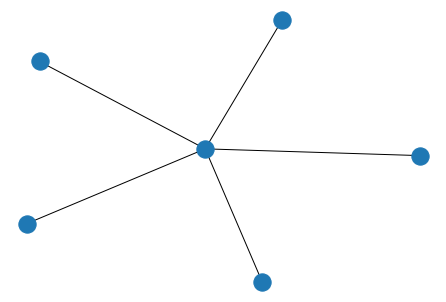

In [14]:
from primitives.actions import Action
from primitives.resources import Function

def requires(resource_a, resource_b):
    assert resource_a is not None
    assert resource_b is not None


# Define requirements
requirements = []
for actor in actors:
    requirements.append(
        Action(
            identifier=f'requires_{actor.identifier}',
            actor=simple_coalition,
            resources=[actor],
            function = Function(
                identifier=f'requires_{actor.identifier}',
                kwargs={'resource_a': simple_coalition, 'resource_b': actor},
                fn=requires,
            )
        )
    )


# Draw Graph    
from graphs.graph import DGraph
dgraph = DGraph()

for rq in requirements:
    dgraph.register_action(rq)
    
dgraph.draw()

## Data & Interfaces (Internal Readers, Oracles, and Writers)
Interfaces act as data connectors from the DAO to internal and external data sources.  An Oracle is a subclass of interface that allows for aggregation and consensus along with values. 

Note, this implementation does not preclude others.  Interfaces and databases are use specific and can be anything that meets the needs of the DAO (ownership, access, control) and the network (performance).

In [7]:
# An Interface can read/write data
# Specify a data store
data = DemoData(
    identifier='DAOCache',
    store=[],
)

# Specify an Interface for that data
interface = Interface(
    identifier='CacheInterface',
    data=data,
)

interface.write({'test_transaction': 'SomeTestDataCouldBeALot'})
interface.write({'another_tx': 'SomeOtherCool Info'})
interface.read()

[{'test_transaction': 'SomeTestDataCouldBeALot'},
 {'another_tx': 'SomeOtherCool Info'}]

#### Modeling An Actor Read/Write
With data and its interface described, we can now specify relations between actors and data sources in the graph

added ['DAOCache', 'CacheInterface'], [('CacheInterface', 'DAOCache', {'function': Function(identifier='SimpleWriteTransaction', kwargs={'interface': CacheInterface}, fn=<function null_fn at 0x7f6d6da88d30>)})]
added ['CacheInterface', 'Mary'], [('Mary', 'CacheInterface', {'function': Function(identifier='SignWrite_Mary', kwargs={'interface': CacheInterface}, fn=<function null_fn at 0x7f6d6da88d30>)})]
added ['CacheInterface', 'John'], [('John', 'CacheInterface', {'function': Function(identifier='SignWrite_John', kwargs={'interface': CacheInterface}, fn=<function null_fn at 0x7f6d6da88d30>)})]


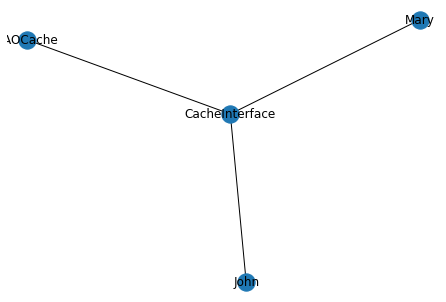

In [1]:
import random

from primitives.actions import Action
from primitives.interfaces import Interface
from primitives.resources import Function, DemoData, Actor, Consensus
from utils.simple_functions import return_true, check_all_true

from graphs.graph import DGraph

# Get prepared data to write
def get_transaction():
    pass 

def null_fn(*args, **kwargs):
    pass


# Specify a data store
data = DemoData(
    identifier='DAOCache',
    store=[],
)

# Specify an Interface for that data
interface = Interface(
    identifier='CacheInterface',
    data=data,
)

# Create some Actors that use the interface
actors = [
    Actor(identifier='Mary', consensus=Consensus(fn=return_true), key=str(random.randint(10000,1000000))),
    Actor(identifier='John', consensus=Consensus(fn=return_true), key=str(random.randint(10000,1000000))),
]


# Specify a sign/write Action from the actors to the interface
def build_sign_write(actor:Actor, interface:Interface) -> Action:
    return Action(
        identifier=f'SignWrite_{actor.identifier}',
        actor=actor,
        resources=[interface],
        function=Function(
            identifier=f'SignWrite_{actor.identifier}',
            kwargs={'interface':interface},
            fn=null_fn
        )
    )
    


# Specify a Write Transaction Action from the interface to the data
write_cache = Action(
    identifier='WriteCache',
    actor=interface,
    resources=[data],
    function=Function(
        identifier='SimpleWriteTransaction',
        kwargs={'interface':interface},
        fn=null_fn,  ## The function is expected to call any oracles or information into memory to build the write!
    )
)

# Compile the actions and define the graph
actions = [
    write_cache,
    build_sign_write(actors[0], interface),
    build_sign_write(actors[1], interface),
]

# Build the graph
dg = DGraph()
for action in actions:
    dg.register_action(action)
    
# Visualize the graph
dg.draw(with_labels=True)

### Oracles - A combination of actor signatures and read interfaces; extends Actor again.
Oracles can participate in coalitions, and so must be actors that can verify their actions via signature.  To accomplish this in a transparent way within this framework, we'll use an actor, and interface, and a datasource.

In [1]:
from primitives.actions import Action
from primitives.resources import Function, DemoData, Interface, Actor, Consensus, Data
from utils.simple_functions import build_read_from_interface, return_true

import random


class Oracle(Actor):
    interface: Interface
    data: Data
        
    def collect(self, *args, **kwargs):
        if self.consensus.resolve(*args, **kwargs):
            return self.sign(
                {'data': self.interface.read(*args, **kwargs)}
            )
        
    # Oracles have an associated action.
    #  Register the Action to build the graph
    @property
    def action(self) -> Action:
        return Action(
            identifier=self.identifier,
            resources=[self.interface, self.data],
            function=self.build_oracle_function(),
            actor=self.interface,
        )
    
    def build_oracle_function(self):
        return Function(
            identifier=self.identifier,
            kwargs={'interface': self.interface},
            fn=build_read_from_interface(self.interface)
        )
    
    

ImportError: cannot import name 'Interface' from 'primitives.resources' (/mnt/c/Users/vince/Bin/graphdao/primitives/resources.py)

In [3]:
# Specify a data store
data = DemoData(
    identifier='OracleSource',
    store=['SecretsFromTheOracle'],
)

# Specify an Interface for that data
interface = Interface(
    identifier='OracleInterface',
    data=data,
)

oracle = Oracle(
    identifier='DemoOracle', 
    consensus=Consensus(fn=return_true), 
    key=str(random.randint(10000,1000000)),
    interface=interface,
    data=data,
)

oracle.collect()

{'data': ['SecretsFromTheOracle'],
 'signatures': [{'DemoOracle': '59a2ecdedbcff1c7c4657f1c7a60b7fe'}]}

#### Registering an Oracle or Resource in general
Composite objects that have implicit actions need to be registered with the graph.  This can be done with a simple check of attribute, making registration simpler in the sense that you can register all objects and actions used to define the DAO and extract actions as you go.

identifier='DemoOracle' resources=[OracleInterface, OracleSource] function=Function(identifier='DemoOracle', kwargs={'interface': OracleInterface}, fn=<function build_read_from_interface.<locals>.read_from_interface at 0x7f9fec743790>) actor=OracleInterface
True
added ['OracleInterface', 'OracleSource', 'OracleInterface'], [('OracleInterface', 'OracleInterface', {'function': Function(identifier='DemoOracle', kwargs={'interface': OracleInterface}, fn=<function build_read_from_interface.<locals>.read_from_interface at 0x7f9fde7e33a0>)}), ('OracleInterface', 'OracleSource', {'function': Function(identifier='DemoOracle', kwargs={'interface': OracleInterface}, fn=<function build_read_from_interface.<locals>.read_from_interface at 0x7f9fde7e33a0>)})]


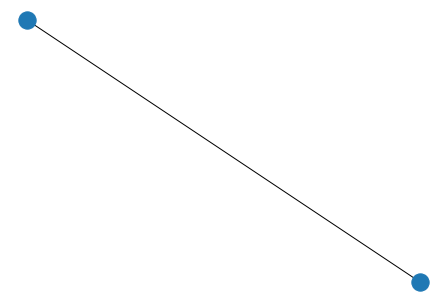

In [4]:
print(oracle.action)  # See the action details
print(hasattr(oracle, 'action'))  # Example test of 'actor' to see if it has an action to register

from graphs.graph import DGraph

dgraph = DGraph()

if hasattr(oracle, 'action'):
    dgraph.register_action(oracle.action)

dgraph.draw()

### Some Useful Oracles

1. UserInputOracle

    Data is an input field with await characteristics

In [6]:
from primitives.oracles import Oracle
from primitives.resources import UserInput, Consensus
from primitives.interfaces import Interface
from utils.simple_functions import return_true

import random 


user_input_data = UserInput(
    identifier='UserInputData',
    store=None,
    message='Please Provide User Data: ',
)

user_input_interface = Interface(
    identifier='UserInputInterface',
    data=user_input_data,
)

user_input_oracle = Oracle(
    identifier='UserInputOracle', 
    consensus=Consensus(fn=return_true), 
    key=str(random.randint(10000,1000000)),
    interface=user_input_interface,
    data=user_input_data,
    cache_reset=2,
)

user_input_oracle.collect()

Please Provide User Data: aedfgqawrhfacfadsd


{'data': 'aedfgqawrhfacfadsd',
 'signatures': [{'UserInputOracle': 'bf96d50e501b6317a986d3223a02d843'}]}

### Use an Oracle for actor consensus
Sometimes, consensus rules will depend on interpretation (by human users or programmatic logic) of oracle data.  Here we demonstrate a user accepting data that the oracle has cached.

Note that in this implementation, Oracle caches have a limited number of hits.  We'll allow one read per expected reviewer before the oracle fetches a new user input to test. Read privileges could also written into the oracle in the future.

In [1]:
from primitives.oracles import Oracle
from primitives.resources import UserInput, Consensus, Coalition, Actor, DemoData, Function
from primitives.interfaces import Interface
from primitives.actions import Action
from utils.simple_functions import check_all_true, return_true

from graphs.graph import DGraph

dgraph = DGraph()

import random

# Mock an oracle with cached data
class MockOracle():
    def collect(self): return 'some data'
source=MockOracle()

def get_data_from_source(source=source):
    return source.collect()


# Define the inputs and interface required to get data from the user
user_approval = UserInput(
    identifier='UserApprovalData',
    store=None,
    message=f'Do You approve of the following: \n{get_data_from_source()}\n(Y/N): ',
)

user_approval_interface = Interface(
    identifier='UserApprovalInterface',
    data=user_approval,
)


# Define a consensus function
def check_user_approval(interface, valid_approvals=['y', 'true']):
    return interface.read().lower() in valid_approvals


# Build Consensus
user_acceptance_consensus = Consensus(
    fn=Function(
        identifier='UserApprovalFunction',
        kwargs={'interface': user_approval_interface},
        fn=check_user_approval
    )
)
    

In [2]:
user_acceptance_consensus.resolve()

Do You approve of the following: 
some data
(Y/N): y


True

## Builing a Coalition Transaction
Many use cases require multiple inputs to be coalesced into a transaction.  Here we'll define a coalition of oracles and actors and storing that transaction.

Please Provide User Data: Imagine this is engagement context.  We met at that place at that time. Remember?
identifier='UserApprovalInterface' data=UserApprovalData fn=<function null_fn at 0x7faf207fc0d0> <class 'primitives.interfaces.Interface'>
identifier='UserApprovalInterface' data=UserApprovalData fn=<function null_fn at 0x7faf207fc0d0> <class 'primitives.interfaces.Interface'>
Do You approve of the following: 
{'data': 'Imagine this is engagement context.  We met at that place at that time. Remember?', 'signatures': [{'UserInputOracle': '5ad203103347c920a6cfa134e15e91d1'}]}
(Y/N): y
Do You approve of the following: 
{'data': 'Imagine this is engagement context.  We met at that place at that time. Remember?', 'signatures': [{'UserInputOracle': '5ad203103347c920a6cfa134e15e91d1'}]}
(Y/N): y
[{'data': 'Imagine this is engagement context.  We met at that place at that time. Remember?', 'signatures': [{'UserInputOracle': '5ad203103347c920a6cfa134e15e91d1'}, {'reviewer_a': '703541d8afa

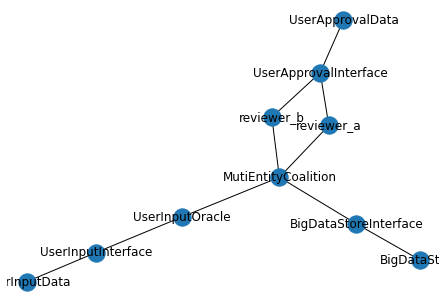

In [2]:
from primitives.oracles import Oracle
from primitives.resources import UserInput, Consensus, Coalition, Actor, DemoData, Function
from primitives.interfaces import Interface
from primitives.actions import Action
from utils.simple_functions import check_all_true, return_true

from graphs.graph import DGraph

dgraph = DGraph()

import random

# Collect some user data
user_input_data = UserInput(
    identifier='UserInputData',
    store=None,
    message='Please Provide User Data: ',
)

user_input_interface = Interface(
    identifier='UserInputInterface',
    data=user_input_data,
)

user_input_oracle = Oracle(
    identifier='UserInputOracle', 
    consensus=Consensus(fn=return_true), 
    key=str(random.randint(10000,1000000)),
    interface=user_input_interface,
    data=user_input_data,
)

# Let's build consensus around the user input, enforcing that both actors sign they agree to the input.

# Define the inputs and interface required to get data from the user
user_approval = UserInput(
    identifier='UserApprovalData',
    store=None,
    message=f'Do You approve of the following: \n{user_input_oracle.collect()}\n(Y/N): ',
)

user_approval_interface = Interface(
    identifier='UserApprovalInterface',
    data=user_approval,
)


# Define a consensus function
def check_user_approval(interface, valid_approvals=['y', 'true']):
    return interface.read().lower() in valid_approvals


# Build Consensus
user_acceptance_consensus = Consensus(
    fn=Function(
        identifier='UserApprovalFunction',
        kwargs={'interface': user_approval_interface},
        fn=check_user_approval
    )
)


# A Couple Actors that need to certify the data
actors = [
    Actor(identifier='reviewer_a', consensus=user_acceptance_consensus, key=str(random.randint(10000,1000000))),
    Actor(identifier='reviewer_b', consensus=user_acceptance_consensus, key=str(random.randint(10000,1000000))),
    user_input_oracle,
]


# A coalition of actors and the oracle
coalition = Coalition(
    identifier='MutiEntityCoalition',
    actors=actors,
    consensus=Consensus(fn=check_all_true),
    key='AHeterogeneousCoalition!',
)

# Specify a data store
datastore = DemoData(
    identifier='BigDataStore',
    store=[],
)

# Specify an Interface for that data
interface = Interface(
    identifier='BigDataStoreInterface',
    data=datastore,
)


# Let's define the function that will use these resources
def create_transaction(coalition: Actor, input_oracle: UserInput, data_interface: Interface):
    # get user input data first
    data = input_oracle.collect()
    # Have coalition sign the transaction
    data = coalition.sign(data)
    # Write the transaction to the interface
    data_interface.write(data)
    
    
# Wrap the function into a standard Function interface
create_transaction_function = Function(
    identifier='create_transaction',
    kwargs={'coalition': coalition, 'input_oracle':user_input_oracle, 'data_interface':interface},
    fn=create_transaction,
)

# Define the Action that the coalition will act on
save_multi_sig = Action(
    identifier='MultiSigOracleTransaction',
    resources=[coalition, interface],
    actor=coalition,
    function=create_transaction_function,
)

# Register the actions with the graph
dgraph.register_action(save_multi_sig)
dgraph.register_actor(actors[0])
dgraph.register_actor(actors[1])
dgraph.register_oracle(user_input_oracle)
dgraph.register_interface(interface)
dgraph.register_interface(user_approval_interface)
dgraph.register_coalition(coalition)


save_multi_sig.execute()
print(interface.read())
dgraph.draw(with_labels=True)

In [4]:
type(user_acceptance_consensus)

primitives.resources.Consensus

In [7]:
hasattr(user_acceptance_consensus.fn, 'identifier')

True

## Adding Directionality - TODO
By focusing on directionality, it becomes easier to find the 'starting' point for any step or series of computations.

